### A Model of the _Drosophila_ Antennal Lobe
So far we've played with very small network models to introduce you to the 
basics of using `NEURON`. Now it's time to up the ante and simulate a couple
thousand neurons in the antennal lobe of _Drosophila_:

In [1]:
import neuron
import navis.interfaces.neuron as nrn

import pandas as pd

from neuron import h
from neuron.units import ms, mV, µm

h.load_file("stdrun.hoc")

1.0

Load the edge list and annotations for FlyWire 

In [2]:
edges = pd.read_feather("../data/syn_proof_analysis_filtered_630.feather")
edges.head()

,pre_pt_root_id,post_pt_root_id,neuropil,syn_count
0,720575940617895883,720575940625455247,LAL_L,4
1,720575940625203277,720575940630882263,CRE_L,1
2,720575940618110513,720575940628422555,PRW,1
3,720575940619938145,720575940616262401,AVLP_L,4
4,720575940620405638,720575940629450622,CRE_R,3


In [4]:
ann = pd.read_csv("../data/Supplemental_file1_annotations.tsv", sep="\t")

# For each neuron this file contains a bunch of meta data:
ann.iloc[0]

/var/folders/b1/1fbq04gx1vg344_ctkmv52d00000gn/T/ipykernel_27075/2508714980.py:1: DtypeWarning: Columns (14,15,16,17,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  ann = pd.read_csv("../data/Supplemental_file1_annotations.tsv", sep="\t")


supervoxel_id               78112261444987077
root_id                    720575940628857210
pos_x                                  109306
pos_y                                   50491
pos_z                                    3960
soma_x                               104904.0
soma_y                                47464.0
soma_z                                 5461.0
nucleus_id                          2453924.0
flow                                intrinsic
super_class                           central
cell_class                                NaN
cell_sub_class                            NaN
cell_type                                 NaN
hemibrain_type                          PS180
ito_lee_hemilineage            SMPpv2_ventral
hartenstein_hemilineage           CP1_ventral
morphology_group             SMPpv2_ventral_3
top_nt                          acetylcholine
top_nt_conf                          0.914499
side                                     left
nerve                             

Let's filter our annotations and edges to the left antennal lobe (AL)

In [5]:
ann_al = ann[
    ann.cell_class.isin(
        ("ALPN", "ALLN")
    )  # Keep all antennal lobe local & projection neurons
    | (
        (ann.super_class == "sensory") & (ann.cell_class == "olfactory")
    )  # keep olfactory sensory
]
ann_al = ann_al[ann_al.side == "left"]
len(ann_al)

1670

In [6]:
edges_al_left = edges[
    edges.pre_pt_root_id.isin(ann_al.root_id)
    & edges.post_pt_root_id.isin(ann_al.root_id)
]

# Let's also drop weak edges (speeds up the simulation)
edges_al_left = edges_al_left[edges_al_left.syn_count > 3]

edges_al_left = edges_al_left.copy()

len(edges_al_left)

27710

Next, we will invert the inhibitory edge weights

In [7]:
inh = ann_al[ann_al.top_nt == "gaba"]

edges_al_left.loc[
    edges_al_left.pre_pt_root_id.isin(inh.root_id.values), "syn_count"
] *= -1

Now we can initialize the network

In [32]:
net = nrn.PointNetwork.from_edge_list(
    edges_al_left,
    source_col="pre_pt_root_id",
    target_col="post_pt_root_id",
    weight_col="syn_count",
)

# Set the same tau and refrac for all neurons
for n in net.neurons:
    n.process.tau = 2 * ms
    n.process.refrac = 10 * ms

# Let's also add the cell class (sensory, ALLN, ALPN) as labels
net.set_labels(ann_al.set_index("root_id").cell_class.to_dict())

We still need a stimulus to induce some activity. Here, we will take the sensory 
neurons that terminate in the DM1 glomerulus (food responsive) and give them 
a good kick. 

The expectation is that the cognate uniglomerular DM1 PN gets activate plus a bit 
of activity in multiglomerular PNs and possibly some local neurons.

In [12]:
# Find the DM1 sensory neurons
dm1 = ann_al[ann_al.hemibrain_type == "ORN_DM1"]
len(dm1)

35

In [33]:
# Add the stimulus
net.add_stimulus(dm1.root_id, start=100, stop=500, frequency=200)

Run the simulation

In [34]:
net.run_simulation(duration=2000)

Plot the results

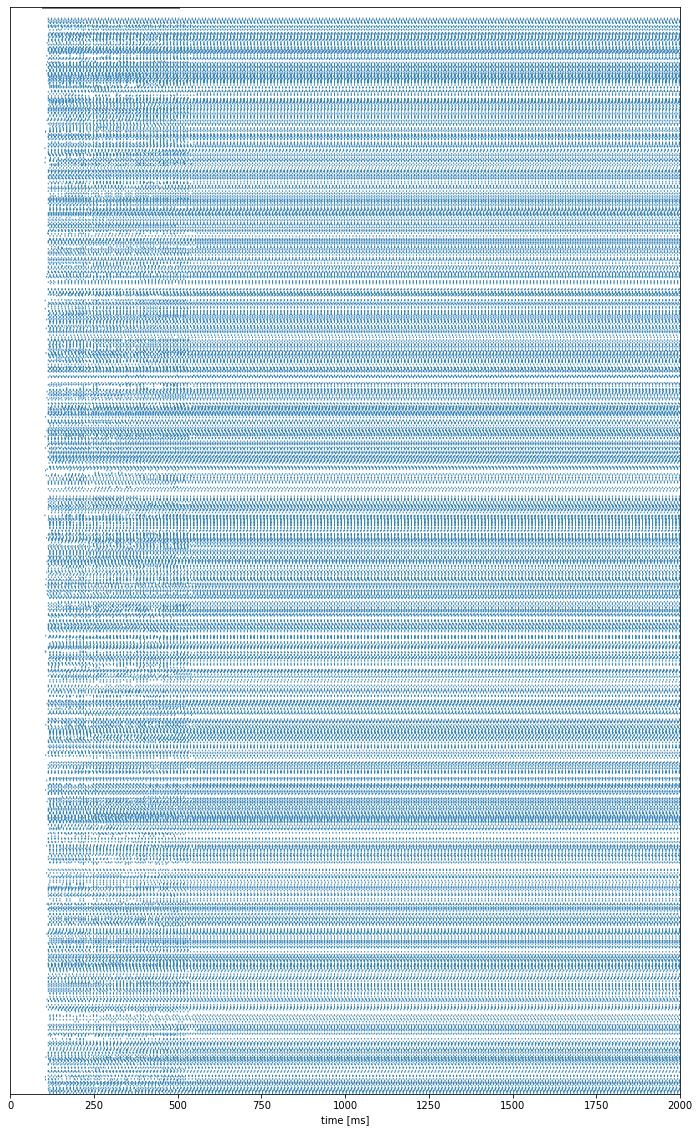

In [38]:
ax = net.plot_raster(backend="matplotlib")

### Parameterization

OK, _something_ happened but we clearly overdid it. This is where the real
fun begins: we need to try and find parameters that make the antennal lobe 
behave more reasonably.

So what can we play with in our model?
1. `tau`
2. `refrac`
3. `weight`
4. stimulus parameters 

The likely culprit here is the edge `weight`. Let's try to semi-systmatically 
test this.

To search the parameter space we should first define some useful metrics. We 
will use:

1. Activity of the DM1 uPN (should be high)
2. Activity of the other uPNs (should be low)
3. Activity of the ALLNs (some but not too much)

In [58]:
def assess_activity(net):
    """Assess output for given simulation."""
    # Collect binned spike counts
    cnt = net.get_spike_counts()

    act_dm1 = cnt.loc[ann_al[(ann_al.hemibrain_type == "DM1_lPN")].root_id].values.sum()
    act_other_pns = (
        cnt.reindex(
            ann_al[
                (ann_al.hemibrain_type != "DM1_uPN")
                & (ann_al.cell_class == "ALPN")
                & (ann_al.cell_sub_class == "uniglomerular")
            ].root_id
        )
        .fillna(0)
        .values.sum()
    )
    act_alln = cnt.loc[ann_al[(ann_al.cell_class == "ALLN")].root_id].values.sum()

    return act_dm1, act_other_pns, act_alln


assess_activity(net)

(189.0, 26419.0, 38372.0)

Now we can set up a parameter search. We will search for separate edge weight
modifiers for excitatory and inhibitory edges.

In [79]:
from tqdm.auto import tqdm

# Setup the modifier we will test
mod_exc = [0.001, 0.005, 0.01, 0.1, 0.5, 1]
mod_inh = [0.1, 0.5, 1, 2, 5, 10, 20, 50, 100]

# Prepare some empty dataframes
act_dm1 = pd.DataFrame(index=mod_exc, columns=mod_inh, dtype=int)
act_alln = pd.DataFrame(index=mod_exc, columns=mod_inh, dtype=int)
act_other = pd.DataFrame(index=mod_exc, columns=mod_inh, dtype=int)

for e_mod in tqdm(mod_exc):
    for i_mod in mod_inh:
        for source, target, weight, nc in net.edges:
            if weight > 0:
                nc.weight[0] = weight * e_mod
            else:
                nc.weight[0] = weight * i_mod

        # Run the simulation
        net.run_simulation(duration=2000)

        # Extract activities
        this_dm1, this_other_pns, this_alln = assess_activity(net)

        # Fill into dataframes
        act_dm1.at[e_mod, i_mod] = this_dm1
        act_alln.at[e_mod, i_mod] = this_alln
        act_other.at[e_mod, i_mod] = this_other_pns

  0%|          | 0/6 [00:00<?, ?it/s]

Plot the results

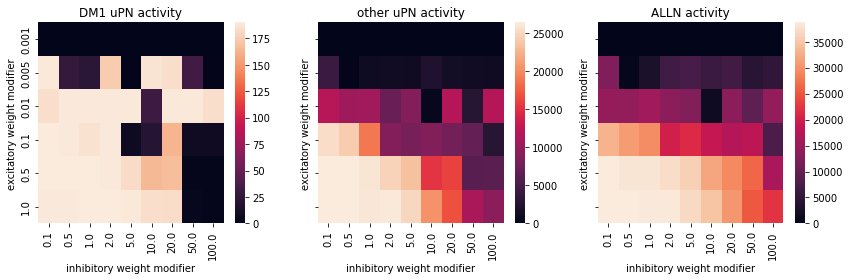

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))
sns.heatmap(act_dm1, ax=axes[0])
sns.heatmap(act_other, ax=axes[1])
sns.heatmap(act_alln, ax=axes[2])

axes[0].set_title("DM1 uPN activity")
axes[1].set_title("other uPN activity")
axes[2].set_title("ALLN activity")

for ax in axes:
    ax.set_ylabel("excitatory weight modifier")
    ax.set_xlabel("inhibitory weight modifier")

plt.tight_layout()

Ok, based on the above we should reduce excitatory weights and increase 
inhibitory weights. Let's give that a try:

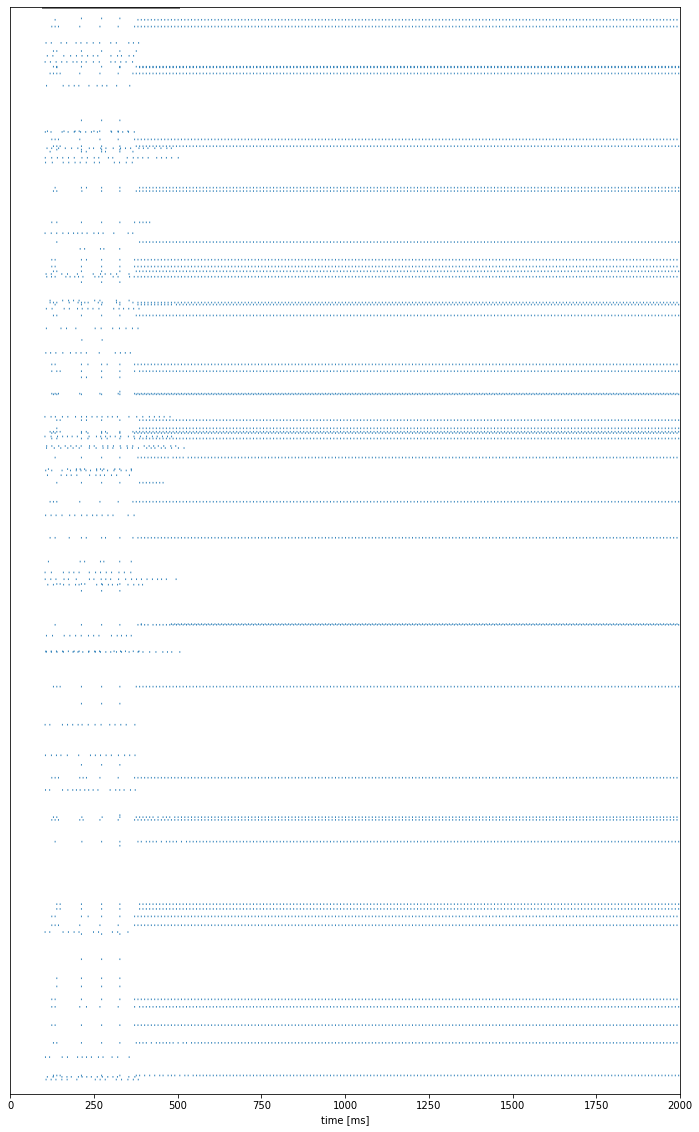

In [102]:
for source, target, weight, nc in net.edges:
    if weight > 0:
        nc.weight[0] = weight * 0.005
    else:
        nc.weight[0] = weight * 20

# Run the simulation
net.run_simulation(duration=2000)

ax = net.plot_raster(backend="matplotlib")

That looks better: sparser activity and it ceases shortly after we stop driving 
the sensory neurons. 

In [103]:
# Generate some salient labels (where applicable)
labels = ann_al.set_index("root_id").cell_class.to_dict()
labels.update(
    ann_al[ann_al.hemibrain_type.notnull()]
    .set_index("root_id")
    .hemibrain_type.to_dict()
)

net.set_labels(labels)

_ = net.plot_traces(group=True)